In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install tensorflow
import tensorflow
#use to deploy various machine learning applications

In [ ]:
!pip install Pillow
!pip install scipy
#Pillow is a library for working with images in Python
#SciPy is a scientific library in Python that builds on the capabilities of NumPy.

In [ ]:
! pip install SimpleITK
#SimpleITK is a Python library that helps people work with medical images like X-rays, MRIs, and CT scans

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 20.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import SimpleITK as sitk

from PIL import Image

%matplotlib inline
#that allows Matplotlib plots to be displayed directly in the notebook.
from IPython.display import clear_output
#clear the output of cells
pd.options.mode.chained_assignment = None

In [ ]:
candidates = pd.read_csv('/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/candidates.csv')

In [ ]:
candidates.head(10)

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.080000,-67.850000,-311.920000,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.210000,-244.410000,-245.170000,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.660000,-121.800000,-286.620000,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.660000,-72.750000,-308.410000,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.250000,-85.360000,-362.510000,0
5,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-26.650000,-203.070000,-165.070000,0
6,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-74.990000,-114.790000,-311.920000,0
7,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-16.140000,-248.610000,-239.550000,0
8,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,135.890000,-141.410000,-252.200000,0
9,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,90.102285,-68.430847,-218.243396,0


In [ ]:
candidates.shape

(551065, 5)

In [ ]:
candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551065 entries, 0 to 551064
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   seriesuid  551065 non-null  object 
 1   coordX     551065 non-null  float64
 2   coordY     551065 non-null  float64
 3   coordZ     551065 non-null  float64
 4   class      551065 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 21.0+ MB


In [ ]:
print(len(candidates))

551065


In [ ]:
print(len(candidates[candidates['class'] == 1]))
print(len(candidates[candidates['class'] == 0]))

1351
549714


In [ ]:
class CTScan(object):
    def __init__(self, filename = None, coords = None):
        self.filename = filename
        self.coords = coords
        self.ds = None
        self.image = None

    def reset_coords(self, coords):
        self.coords = coords

    def read_mhd_image(self):
        path = glob.glob('/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/seg-lungs-LUNA16/*/'+ self.filename + '.mhd')
        self.ds = sitk.ReadImage(path[0])
        #reading mhd files
        self.image = sitk.GetArrayFromImage(self.ds)

    def get_resolution(self):
        return self.ds.GetSpacing()

    def get_origin(self):
        return self.ds.GetOrigin()

    def get_ds(self):
        return self.ds

    def get_voxel_coords(self):
      #calculates voxel coordinates from
        origin = self.get_origin()
        resolution = self.get_resolution()
        voxel_coords = [np.absolute(self.coords[j]-origin[j])/resolution[j] \
            for j in range(len(self.coords))]
        return tuple(voxel_coords)

    def get_image(self):
        return self.image

    def get_subimage(self, width):
        self.read_mhd_image()
        x, y, z = self.get_voxel_coords()
        subImage = self.image[z, y-width/2:y+width/2, x-width/2:x+width/2]
        return subImage
    def normalizePlanes(self, npzarray):
        maxHU = 400.
        minHU = -1000.
        npzarray = (npzarray - minHU) / (maxHU - minHU)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray
        #it performs HU(Hounsfield Unit) value normalization for better visualization and analysis of the CT scan data.

    def save_image(self, filename, width):
        image = self.get_subimage(width)
        image = self.normalizePlanes(image)
        Image.fromarray(image*255).convert('L').save(filename)

        '''Initialization
        Reading MHD Image
        Image Information :retrieve information about the image, such as resolution, origin, the SimpleITK image object (ds), and voxel coordinates.
        Subimage Extraction
        Image Normalization
        Image Saving '''

In [ ]:
positives = candidates[candidates['class']==1].index
negatives = candidates[candidates['class']==0].index

In [ ]:
filename = '1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208'
coords = (70.19, -140.93, 877.68)#[877.68, -140.93, 70.19]
scan = CTScan(filename, coords)
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()
'''
scan object to work with a specific CT scan image, loads the image, and retrieves important information about the image,
such as its coordinates, pixel data, resolution, and origin
'''

'\nscan object to work with a specific CT scan image, loads the image, and retrieves important information about the image,\nsuch as its coordinates, pixel data, resolution, and origin\n'

In [ ]:
positives

Int64Index([    13,     78,   1303,   3050,   3052,   3080,   3223,   3285,
              3287,   3289,
            ...
            545928, 546205, 546372, 546400, 547498, 548674, 550171, 550334,
            550810, 550906],
           dtype='int64', length=1351)

In [ ]:
#Setting the random seed for reproducibility
np.random.seed(42)
negIndexes = np.random.choice(negatives, len(positives)*5, replace = False)

In [ ]:
candidatesDf = candidates.iloc[list(positives)+list(negIndexes)]

In [ ]:
from sklearn.model_selection import train_test_split
X = candidatesDf.iloc[:,:-1]
y = candidatesDf.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [ ]:
X_train.size

25936

In [ ]:
y_train

178085    0
108126    0
416697    0
342095    0
116478    0
         ..
469116    0
164439    0
333192    1
358382    0
536292    0
Name: class, Length: 6484, dtype: int64

In [ ]:
y_test

189342    0
145102    0
31546     0
441280    1
215578    0
         ..
87015     0
245189    0
533231    0
52755     0
379730    0
Name: class, Length: 1622, dtype: int64

In [ ]:
X_train.size

25936

In [ ]:
X_train

,seriesuid,coordX,coordY,coordZ
178085,1.3.6.1.4.1.14519.5.2.1.6279.6001.197063290812...,87.067400,10.630703,-200.265200
108126,1.3.6.1.4.1.14519.5.2.1.6279.6001.160586340600...,-96.725236,15.697794,-128.547059
416697,1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394...,-9.682281,-59.645492,-187.549413
342095,1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214...,91.246952,81.410143,-116.704565
116478,1.3.6.1.4.1.14519.5.2.1.6279.6001.164790817284...,60.356159,-121.076049,-227.864724
...,...,...,...,...
469116,1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011...,-30.774544,34.393634,-141.628406
164439,1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346...,-47.016667,-31.364583,-122.572917
333192,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644...,75.721224,92.887331,-119.270564
358382,1.3.6.1.4.1.14519.5.2.1.6279.6001.303066851236...,-109.016269,-119.754000,-208.902885


In [ ]:
y_train

178085    0
108126    0
416697    0
342095    0
116478    0
         ..
469116    0
164439    0
333192    1
358382    0
536292    0
Name: class, Length: 6484, dtype: int64

In [ ]:
len(X_train)

6484

In [ ]:
tempDf = X_train[y_train == 1]
tempDf = tempDf.set_index(X_train[y_train == 1].index + 1000000)
X_train_new = X_train.append(tempDf)
tempDf = tempDf.set_index(X_train[y_train == 1].index + 2000000)
X_train_new = X_train_new.append(tempDf)

ytemp = y_train.reindex(X_train[y_train == 1].index + 1000000)
ytemp.loc[:] = 1
y_train_new = y_train.append(ytemp)
ytemp = y_train.reindex(X_train[y_train == 1].index + 2000000)
ytemp.loc[:] = 1
y_train_new = y_train_new.append(ytemp)
#for balancing oversampling of positive class
#to distinguish between new dataframe and orginal records
print(len(X_train_new), len(y_train_new))

8622 8622


<ipython-input-26-91bf4be09021>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train_new = X_train.append(tempDf)
<ipython-input-26-91bf4be09021>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train_new = X_train_new.append(tempDf)
<ipython-input-26-91bf4be09021>:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train_new = y_train.append(ytemp)
<ipython-input-26-91bf4be09021>:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train_new = y_train_new.append(ytemp)


In [ ]:
X_train_new

,seriesuid,coordX,coordY,coordZ
178085,1.3.6.1.4.1.14519.5.2.1.6279.6001.197063290812...,87.067400,10.630703,-200.265200
108126,1.3.6.1.4.1.14519.5.2.1.6279.6001.160586340600...,-96.725236,15.697794,-128.547059
416697,1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394...,-9.682281,-59.645492,-187.549413
342095,1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214...,91.246952,81.410143,-116.704565
116478,1.3.6.1.4.1.14519.5.2.1.6279.6001.164790817284...,60.356159,-121.076049,-227.864724
...,...,...,...,...
2474978,1.3.6.1.4.1.14519.5.2.1.6279.6001.616033753016...,78.998061,56.197240,-154.067627
2301797,1.3.6.1.4.1.14519.5.2.1.6279.6001.268030488196...,73.086669,69.839425,-36.285210
2053377,1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637...,-95.430332,-87.698460,1131.880131
2186995,1.3.6.1.4.1.14519.5.2.1.6279.6001.200841000324...,-108.323597,69.846003,-107.075482


In [ ]:
y_train_new

178085     0.0
108126     0.0
416697     0.0
342095     0.0
116478     0.0
          ... 
2474978    1.0
2301797    1.0
2053377    1.0
2186995    1.0
2333192    1.0
Name: class, Length: 8622, dtype: float64

In [ ]:
X_train_new.index

Int64Index([ 178085,  108126,  416697,  342095,  116478,  400429,  172244,
             481432,  142458,  470796,
            ...
            2518381, 2081673, 2377684, 2429040, 2189029, 2474978, 2301797,
            2053377, 2186995, 2333192],
           dtype='int64', length=8622)

In [ ]:
import scipy.misc
# image processing
import cv2
#various computer vision tasks

In [ ]:
from PIL import ImageEnhance

class PreProcessing(object):
    def __init__(self, image = None):
        self.image = image

    def subtract_mean(self):        #adjusting image brightness by shifting mean
        self.image = (self.image/255.0 - 0.25)*255
        return self.image

    def downsample_data(self):       # reduces the image's size
        self.image = cv2.resize(self.image, (40,40), interpolation = cv2.INTER_AREA)
        return self.image

    def upsample_data(self):         # increases the image's size
        self.image = cv2.resize(self.image, (224, 224), interpolation = cv2.INTER_CUBIC)
        return self.image

In [ ]:
from matplotlib.pyplot import imread

#inp = cv2.imread(dirName + 'image_' + str(30517) + '.jpg', cv2.IMREAD_GRAYSCALE)

Original shape of input image: (50, 50)


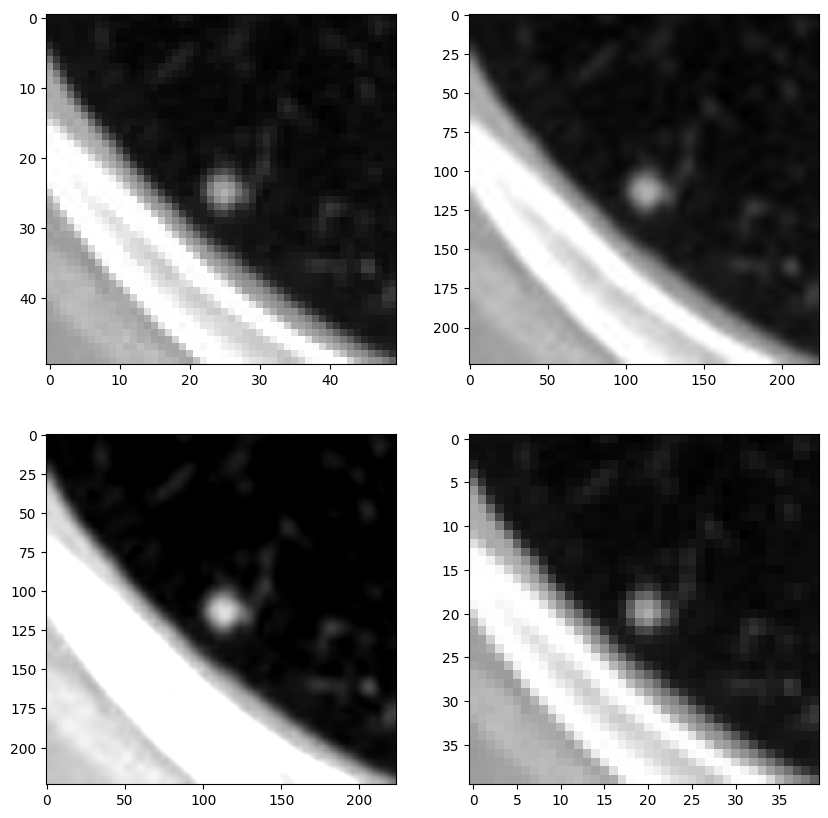

In [ ]:

# Assuming you have the PreProcessing class defined

dirName = '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/'

plt.figure(figsize=(10, 10))

# Define the image file path
img_path = dirName + 'image_' + str(30517) + '.jpg'

# Check if the image file exists
if cv2.os.path.exists(img_path):
    # Load the image in grayscale
    inp = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if inp is not None:
        print("Original shape of input image:", inp.shape)
        plt.subplot(221)
        plt.imshow(inp, cmap='gray')
        plt.grid(False)

        # Assuming you have the PreProcessing class defined
        inp = PreProcessing(inp).upsample_data()
        Pp = PreProcessing(inp)

        inp2 = Pp.subtract_mean()
        plt.subplot(222)
        plt.imshow(inp2, cmap='gray')
        plt.grid(False)

        inp3 = ImageEnhance.Contrast(Image.fromarray(inp))
        contrast = 1.5
        inp3 = inp3.enhance(contrast)
        plt.subplot(223)
        plt.imshow(inp3, cmap='gray')
        plt.grid(False)

        inp4 = Pp.downsample_data()
        plt.subplot(224)
        plt.imshow(inp4, cmap='gray')
        plt.grid(False)

    else:
        print("Image not loaded.")
else:
    print("Image file not found at:", img_path)

plt.show()

In [ ]:
inp.shape

(224, 224)

In [ ]:
inp.dtype

dtype('uint8')

In [ ]:
y_train_new.values.astype(int)

array([0, 0, 0, ..., 1, 1, 1])

**Training**

In [ ]:
train_filenames =\
X_train_new.index.to_series().apply(lambda x:\
                                    '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_'+str(x)+'.jpg')
train_filenames.values.astype(str)

array(['/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_178085.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_108126.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_416697.jpg',
       ...,
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_2053377.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_2186995.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_2333192.jpg'],
      dtype='<U80')

In [ ]:
dataset_file = 'traindatalabels.txt'
filenames = train_filenames.values.astype(str)
train_filenames =X_train_new.index.to_series().apply(lambda x:filenames)
labels = y_train_new.values.astype(int)
traindata = np.zeros(filenames.size,\
                     dtype=[('var1', 'S36'), ('var2', int)])
traindata['var1'] = filenames
traindata['var2'] = labels

np.savetxt(dataset_file, traindata, fmt="%10s %d")

In [ ]:
traindata

array([(b'/content/gdrive/My Drive/lungcancer/', 0),
       (b'/content/gdrive/My Drive/lungcancer/', 0),
       (b'/content/gdrive/My Drive/lungcancer/', 0), ...,
       (b'/content/gdrive/My Drive/lungcancer/', 1),
       (b'/content/gdrive/My Drive/lungcancer/', 1),
       (b'/content/gdrive/My Drive/lungcancer/', 1)],
      dtype=[('var1', 'S36'), ('var2', '<i8')])

In [ ]:
#import tflearn

In [ ]:
# Build a HDF5 dataset (only required once)
#from tflearn.data_utils import build_hdf5_image_dataset
#build_hdf5_image_dataset(dataset_file, image_shape=(50, 50), mode='file', output_path='traindataset.h5', categorical_labels=True, normalize=True)

In [ ]:
# Load HDF5 dataset
import h5py
h5f = h5py.File('/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/traindataset.h5', 'r')
X_train_images = h5f['X']
Y_train_labels = h5f['Y']

h5f2 = h5py.File('/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/valdataset.h5', 'r')
X_val_images = h5f2['X']
Y_val_labels = h5f2['Y']

In [ ]:
X_train_images

<HDF5 dataset "X": shape (5187, 50, 50), type "<f4">

In [ ]:
Y_train_labels

<HDF5 dataset "Y": shape (5187, 2), type "<f4">

**TESTING IMAGE PROCESSING**

In [ ]:
X_train_processing = np.array(X_train_images)
X_val_processing = np.array(X_val_images)
print(X_train_processing.shape)
print(X_val_processing.shape)
print(X_train_processing.dtype)
print(X_val_processing.dtype)

(5187, 50, 50)
(1297, 50, 50)
float32
float32


In [ ]:
img_test = X_train_processing[1000]
img_test_downsampled = PreProcessing(img_test).downsample_data()
img_test_upsampled = PreProcessing(img_test).upsample_data()

In [ ]:
print(Y_train_labels[1000])

[1. 0.]


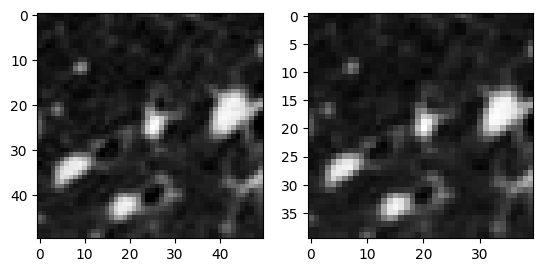

In [ ]:
plt.subplot(121)
plt.imshow(img_test,cmap='gray')
plt.subplot(122)
plt.imshow(img_test_downsampled,cmap='gray')

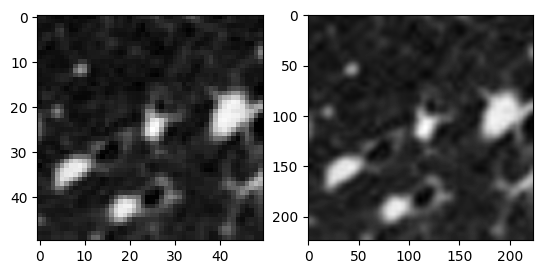

In [ ]:
plt.subplot(121)
plt.imshow(img_test,cmap='gray')
plt.subplot(122)
plt.imshow(img_test_upsampled,cmap='gray')

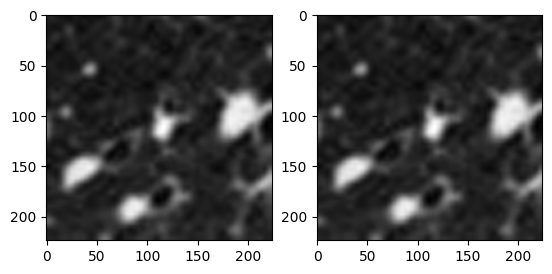

In [ ]:
img_test_subtracted_mean = PreProcessing(img_test_upsampled).subtract_mean()
plt.subplot(121)
plt.imshow(img_test_upsampled,cmap='gray')
plt.subplot(122)
plt.imshow(img_test_subtracted_mean,cmap='gray')

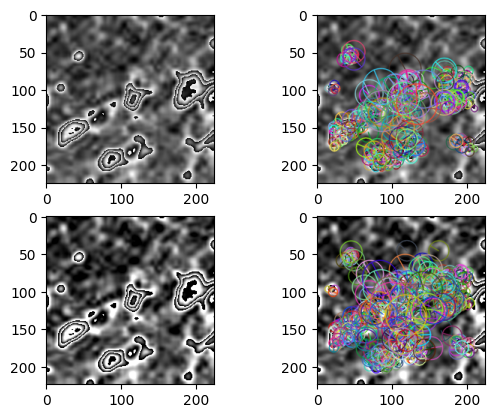

In [ ]:
import cv2
#BRISK to detect keypoints in images
brisk = cv2.BRISK_create(50)
img_BRISK_1 = img_test_upsampled.copy()
#This is typically done to avoid modifying the original image.
rgb = cv2.cvtColor(img_BRISK_1, cv2.COLOR_GRAY2RGB)
#convert the grayscale image to an RGB image.
img_BRISK_2 = rgb*1000
img_BRISK_3 = np.array(img_BRISK_2, dtype=np.uint8)
#convert the scaled image (img_BRISK_2) to an array with a data type of unsigned 8-bit integers (np.uint8)
img_contr_copy = img_BRISK_3.copy()
#create a copy of the image after the scaling operation

img_BRISK_1 = img_test_upsampled.copy()
rgb = cv2.cvtColor(img_BRISK_1, cv2.COLOR_GRAY2RGB)
img_BRISK_2 = rgb*1000
img_BRISK_3 = np.array(img_BRISK_2, dtype=np.uint8)
img_contr_copy = img_BRISK_3.copy()


#uses matplotlib to create a subplot where the original image
plt.subplot(221)
plt.imshow(img_BRISK_3, cmap='gray')

#Detect and Compute Keypoints:

kpts_1, des_1 = brisk.detectAndCompute(img_BRISK_3, None)

#Detect and Compute Keypoints:

image_BRISK_1 = cv2.drawKeypoints(image=img_BRISK_3, outImage=img_BRISK_3, keypoints=kpts_1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.subplot(222)
plt.imshow(image_BRISK_1, cmap='gray')


# with enhanced contrast
#Contrast Enhancement
inp_contr = ImageEnhance.Contrast(Image.fromarray(img_contr_copy))
contrast = 1.5
img_contr = inp_contr.enhance(contrast)

#Display Image with Enhanced Contrast
plt.subplot(223)
plt.imshow(img_contr, cmap='gray')

#Detect and Compute Keypoints on Enhanced Image
img_BRISK_4 = np.array(img_contr)
kpts_2, des_2 = brisk.detectAndCompute(img_BRISK_4, None)

image_BRISK_2 = cv2.drawKeypoints(image=img_BRISK_4, outImage=img_BRISK_4, keypoints=kpts_2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.subplot(224)
plt.imshow(image_BRISK_2, cmap='gray')

In [ ]:
X_train_images_np = np.expand_dims(np.array(X_train_images), axis = 3)
y_train_labels_np = np.array(Y_train_labels)
X_val_images_np = np.expand_dims(np.array(X_val_images), axis = 3)
y_val_labels_np = np.array(Y_val_labels)
print(X_train_images_np.shape)
print(y_train_labels_np.shape)
print(X_val_images_np.shape)
print(y_val_labels_np.shape)

(5187, 50, 50, 1)
(5187, 2)
(1297, 50, 50, 1)
(1297, 2)


In [ ]:
print(X_train_images_np.dtype)
print(y_train_labels_np.dtype)
print(X_val_images_np.dtype)
print(y_val_labels_np.dtype)

float32
float32
float32
float32


In [ ]:
import h5py

# used for large datasets
file_path = '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/testdataset.h5'

try:
    h5f2 = h5py.File(file_path, 'r')
    X_test_images = h5f2['X']
    Y_test_labels = h5f2['Y']
    for item in X_test_images:
        print(item)
    for item in Y_test_labels:
        print(item)
    h5f2.close()
except FileNotFoundError as e:
    print(f"File not found: {file_path}")
except Exception as e:
    print(f"An error occurred: {str(e)}")

Streaming output truncated to the last 5000 lines.
 ...
 [0.75686276 0.7529412  0.7019608  ... 0.654902   0.627451   0.6117647 ]
 [0.75686276 0.7372549  0.7529412  ... 0.64705884 0.6313726  0.61960787]
 [0.7647059  0.7372549  0.74509805 ... 0.6784314  0.6431373  0.6313726 ]]
[[0.77254903 0.7372549  0.7411765  ... 0.7529412  0.7411765  0.74509805]
 [0.76862746 0.7372549  0.7411765  ... 0.7607843  0.69803923 0.7137255 ]
 [0.7607843  0.73333335 0.7411765  ... 0.7647059  0.7058824  0.72156864]
 ...
 [0.7058824  0.6745098  0.6666667  ... 0.1254902  0.12156863 0.08627451]
 [0.6745098  0.68235296 0.654902   ... 0.06666667 0.08627451 0.07843138]
 [0.6745098  0.68235296 0.6509804  ... 0.10980392 0.07450981 0.06666667]]
[[0.32941177 0.27058825 0.21176471 ... 0.3764706  0.42745098 0.2627451 ]
 [0.57254905 0.5921569  0.6039216  ... 0.49411765 0.4392157  0.36862746]
 [0.63529414 0.69411767 0.84705883 ... 0.5568628  0.6117647  0.59607846]
 ...
 [0.7019608  0.72156864 0.77254903 ... 0.15294118 0.0862

In [ ]:
h5f2 = h5py.File('/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/testdataset.h5', 'r')
X_test_images = h5f2['X']
Y_test_labels = h5f2['Y']

In [ ]:
X_test_images_np = np.expand_dims(np.array(X_test_images), axis = 3)
y_test_labels_np = np.array(Y_test_labels)
print(X_test_images_np.shape)
print(y_test_labels_np.shape)

(1622, 50, 50, 1)
(1622, 2)


In [ ]:
print(X_test_images_np.dtype)
print(y_test_labels_np.dtype)

float32
float32


**MODEL MAKING & MODEL TRAINING**

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization,AveragePooling2D
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
def define_model():
	#Initializing Sequential model i.e., a linear stack of layers, making it suitable for building feedforward neural networks where layers are added in sequence.
	model = Sequential()
 #Adding a convolutional layer with 32 filters (feature maps), a 3x3 filter size, ReLU activation function, 'he_uniform' kernel initialization, and 'same' padding.
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 1)))
	#Normalizing the activations of the layer, which improves training stability and speed.
	model.add(BatchNormalization())
	#Repeating the pattern for different numbers of filters (32, 64, 128), dropout layers (to reduce overfitting and other configurations for several convolutional layers)
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.1))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.5))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'));
	return model

mobile = define_model()

In [ ]:
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 1)))
	model.add(BatchNormalization())
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.1))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.5))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'));
	return model

mobile = define_model()

In [ ]:
mobile.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 50, 50, 32)        320       
                                                                 
 batch_normalization_11 (Ba  (None, 50, 50, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_11 (Conv2D)          (None, 50, 50, 32)        9248      
                                                                 
 batch_normalization_12 (Ba  (None, 50, 50, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 25, 25, 32)        0         
 g2D)                                                            
                                                      

**CONVOLUTIONAL NEURAL NETWORK**

In [ ]:
#assigns the output tensor of a pre-trained model called "mobile" (MobileNet, presumably), that is used for feature extraction
op_layer = mobile.output
#fully connected layer
  #adds a dense layer with 128 units, ReLU activation function on top of the pre-trained model's output, 'he_uniform' initializer is used for weight initialization.
final_layer = Dense(128,activation='relu',kernel_initializer='he_uniform')(op_layer)
  #identical dense layer that is built upon previous layer
final_layer = Dense(128,activation='relu',kernel_initializer='he_uniform')(final_layer)
  #final output layer with 'softmax' activation function that effectively transforms the network's output into probabilities for each of the two classes; making it suitable for making binary classification decisions.
final_layer = Dense(2,activation= 'softmax')(final_layer)
from keras.models  import Model
#Model definition
model = Model(inputs = mobile.input , outputs = final_layer)

In [ ]:
#Compiling it using the Adam optimizer with a learning rate of 0.001 that specifies the loss function and metrics for model evaluation
import keras
optimizer_adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10_input (InputLaye  [(None, 50, 50, 1)]       0         
 r)                                                              
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 32)        320       
                                                                 
 batch_normalization_11 (Ba  (None, 50, 50, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_11 (Conv2D)          (None, 50, 50, 32)        9248      
                                                                 
 batch_normalization_12 (Ba  (None, 50, 50, 32)        128       
 tchNormalization)                                               
                                                             

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(hist,title="Model Accuracy with ReLu Function"):		#hist = Keras history object (typically obtained during model training)
	plt.plot(hist.history["accuracy"])
	plt.plot(hist.history['val_accuracy'])
	plt.plot(hist.history['loss'])
	plt.plot(hist.history['val_loss'])
	plt.title("model accuracy")
	plt.ylabel("Accuracy")
	plt.xlabel("Epoch")
	plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint('classification_deep_conv_model.h5', save_best_only=True), #Saving model's weights during training
    keras.callbacks.ReduceLROnPlateau()]  #Reduces the learning rate when certain conditions are met during training

<ipython-input-67-768b7fff59a7>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(it_train, steps_per_epoch=steps, epochs=30, validation_data=(X_val_images_np, y_val_labels_np), verbose=1, callbacks = callbacks)


Epoch 1/30
81/81 [==============================] - 25s 71ms/step - loss: 0.5181 - accuracy: 0.8161 - val_loss: 0.5082 - val_accuracy: 0.8273 - lr: 0.0010
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 4s 51ms/step - loss: 0.4821 - accuracy: 0.8329 - val_loss: 0.5757 - val_accuracy: 0.8265 - lr: 0.0010
Epoch 3/30
81/81 [==============================] - 4s 50ms/step - loss: 0.4501 - accuracy: 0.8343 - val_loss: 0.4455 - val_accuracy: 0.8273 - lr: 0.0010
Epoch 4/30
81/81 [==============================] - 6s 68ms/step - loss: 0.4384 - accuracy: 0.8331 - val_loss: 0.4292 - val_accuracy: 0.8273 - lr: 0.0010
Epoch 5/30
81/81 [==============================] - 4s 45ms/step - loss: 0.4320 - accuracy: 0.8356 - val_loss: 0.4047 - val_accuracy: 0.8311 - lr: 0.0010
Epoch 6/30
81/81 [==============================] - 4s 45ms/step - loss: 0.4056 - accuracy: 0.8347 - val_loss: 0.3804 - val_accuracy: 0.8327 - lr: 0.0010
Epoch 7/30
81/81 [==============================] - 5s 65ms/step - loss: 0.3829 - accuracy: 0.8351 - val_loss: 0.3681 - val_accuracy: 0.8265 - lr: 0.0010
Epoch 8/30
81/81 [==============================] - 4s 44ms/step - loss: 0.3653 - accur

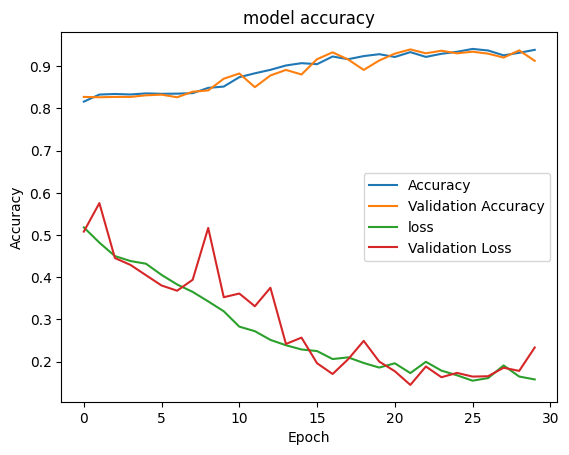

In [ ]:
# run the test harness for evaluating a model
def run_test_harness(title="Model Accuracy with ReLu Function"):
	# create data generator
	datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,zoom_range=0.1)
	# prepare iterator
	it_train = datagen.flow(X_train_images_np, y_train_labels_np, batch_size=64)
	# fit model
	steps = int(X_train_images_np.shape[0] / 64)
	hist = model.fit_generator(it_train, steps_per_epoch=steps, epochs=30, validation_data=(X_val_images_np, y_val_labels_np), verbose=1, callbacks = callbacks)
	# evaluate model
	_, acc = model.evaluate(X_val_images_np, y_val_labels_np, verbose=1)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(hist,title=title)

# entry point, run the test harness
run_test_harness(title="Model Accuracy with ReLu Function")

In [ ]:
model_new_1 = keras.models.load_model("classification_deep_conv_model.h5")

In [ ]:
model_new_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10_input (InputLaye  [(None, 50, 50, 1)]       0         
 r)                                                              
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 32)        320       
                                                                 
 batch_normalization_11 (Ba  (None, 50, 50, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_11 (Conv2D)          (None, 50, 50, 32)        9248      
                                                                 
 batch_normalization_12 (Ba  (None, 50, 50, 32)        128       
 tchNormalization)                                               
                                                             

In [ ]:
#Evaluating performance on test dataset
from sklearn.metrics import confusion_matrix,classification_report
y_pred = model_new_1.predict(X_test_images_np)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test_labels_np,axis=1)
print('CONFUSION MATRIX')
print(confusion_matrix(y_true,y_p))

51/51 [==============================] - 1s 10ms/step
CONFUSION MATRIX
[[1310   30]
 [  60  222]]


In [ ]:
print('Classification report of CNN model with ReLu Activation Function')
print(classification_report(y_true,y_p))

Classification report of CNN model with ReLu Activation Function
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1340
           1       0.88      0.79      0.83       282

    accuracy                           0.94      1622
   macro avg       0.92      0.88      0.90      1622
weighted avg       0.94      0.94      0.94      1622



In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

# Loading the trained model
model_new_1 = load_model("classification_deep_conv_model.h5")

image_path = "image_522956.jpg"
img = Image.open(image_path)
img = img.resize((50, 50))

# Converting the image to a NumPy array
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)

# Making predictions using the loaded model
predictions = model_new_1.predict(img)

# Assuming binary classification with a threshold of 0.5
threshold = 0.5
predicted_class = 1 if predictions[0][0] > threshold else 0

# Printing or use the predicted class
print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 439ms/step
Predicted Class: 0
